/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


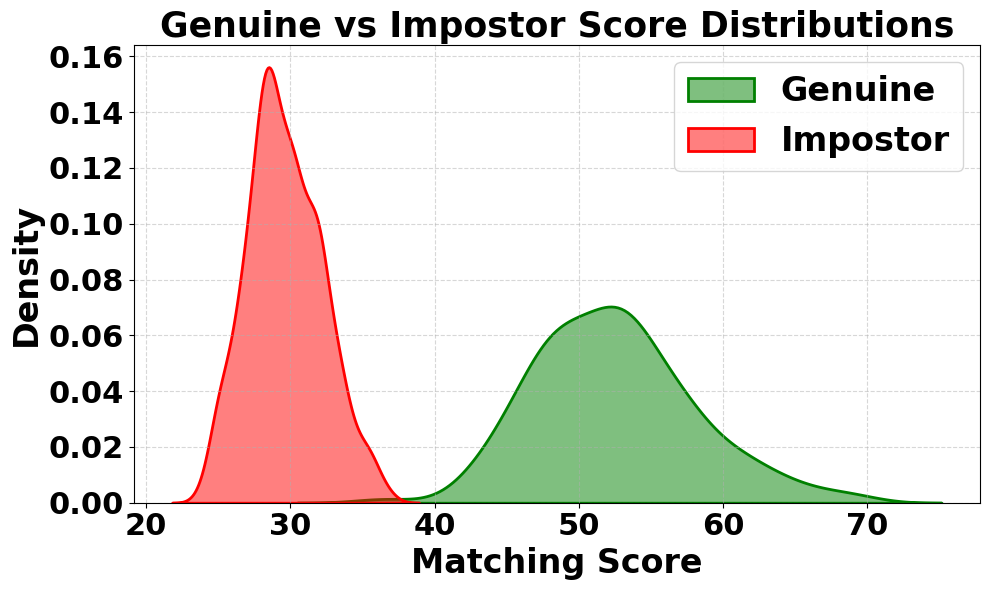

In [39]:
import seaborn as sns

# -------------------
# IEEE-style "Mountain" KDE Plot for Genuine vs Impostor
# -------------------
def plot_genuine_impostor_mountain(genuine, impostor, title="Genuine vs Impostor Score Distributions"):
    plt.figure(figsize=(10,6))
    
    # Kernel density estimation (smoothed)
    sns.kdeplot(genuine, fill=True, color='green', alpha=0.5, linewidth=2, label='Genuine')
    sns.kdeplot(impostor, fill=True, color='red', alpha=0.5, linewidth=2, label='Impostor')
    
    # Mean lines
   # plt.axvline(np.mean(genuine), color='green', linestyle='--', linewidth=2)
    #plt.axvline(np.mean(impostor), color='red', linestyle='--', linewidth=2)    
    # IEEE-style formatting
    plt.title(title, fontsize=25, fontweight='bold')
    plt.xlabel("Matching Score", fontsize=24, fontweight='bold')
    plt.ylabel("Density", fontsize=24, fontweight='bold')
    plt.xticks(fontsize=22, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(frameon=True, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 24})
    plt.tight_layout()
    plt.show()

# Example usage:
plot_genuine_impostor_mountain(genuine, impostor)


Loaded 100 subjects with 8 impressions each.
Train subjects: 70, Test subjects: 30
genuine count = 150, impostor count = 870
mean genuine = 56.4099, mean impostor = 34.5704
mean genuine = 56.5478, mean impostor = 34.4710
mean genuine = 55.6954, mean impostor = 34.6499
mean genuine = 55.8905, mean impostor = 34.5773
mean genuine = 56.9178, mean impostor = 34.7825
mean genuine = 56.5607, mean impostor = 34.6628
mean genuine = 57.0886, mean impostor = 34.5660
mean genuine = 57.0964, mean impostor = 34.3614
mean genuine = 55.8436, mean impostor = 34.7662
mean genuine = 56.9265, mean impostor = 34.4935
mean genuine = 56.4383, mean impostor = 34.6301
mean genuine = 56.4484, mean impostor = 34.8284
mean genuine = 57.0609, mean impostor = 34.5028
mean genuine = 57.0783, mean impostor = 34.4724
mean genuine = 56.9715, mean impostor = 34.3908
mean genuine = 56.4865, mean impostor = 34.5993
mean genuine = 55.5634, mean impostor = 34.4965
mean genuine = 56.8561, mean impostor = 34.7449
mean genuin

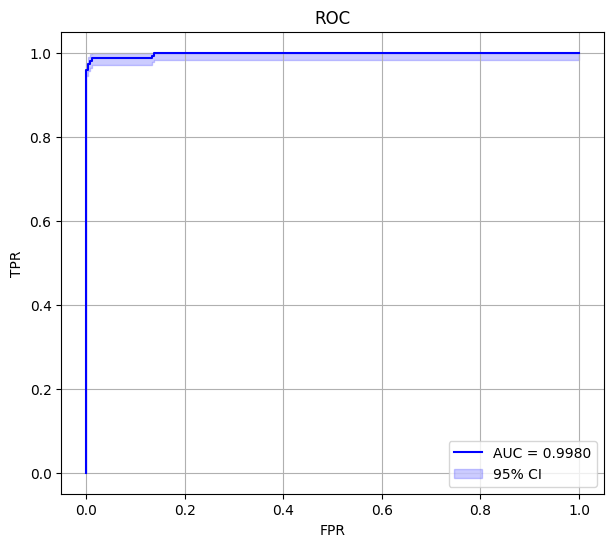

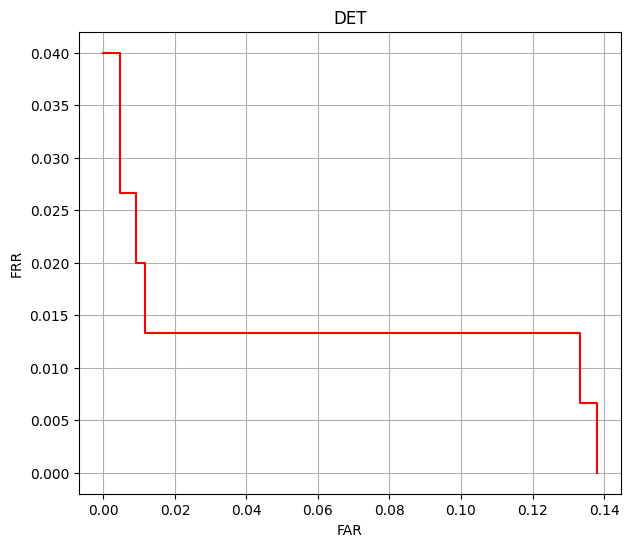

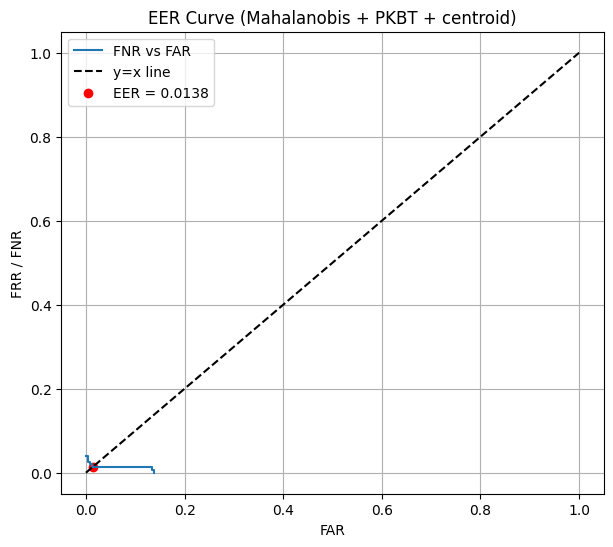

In [29]:
# Fully updated & debug-friendly script with ROC CI, DET, and EER curves
import os
import cv2
import numpy as np
from scipy.signal import hilbert
from sklearn.metrics import roc_curve, auc, det_curve
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten
from sklearn.covariance import LedoitWolf
import random

# -------------------
# Config
# -------------------
IMAGE_SIZE = (224, 224)
DATASET_PATH = "/kaggle/input/fycalldaatsetsss/74034_3_En_4_MOESM1_ESM/FVC2000/Dbs/Db2_a"
NUM_SUBJECTS = 100
NUM_IMPRESSIONS = 8
ENROLL_IMPRESSIONS = 3
PROBE_IMPRESSIONS = NUM_IMPRESSIONS - ENROLL_IMPRESSIONS
KEY = None
TRAIN_SPLIT = 0.7
RANDOM_SEED = 42
BOOTSTRAP_N = 500

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# -------------------
# Utils / Loader
# -------------------
def load_dataset(dataset_path):
    subjects = {}
    for file in sorted(os.listdir(dataset_path)):
        if file.lower().endswith(".tif"):
            name = file.replace(".tif", "")
            parts = name.split("_")
            if len(parts) < 2:
                continue
            try:
                subj = int(parts[0])
            except:
                continue
            img_path = os.path.join(dataset_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            subjects.setdefault(subj, []).append(img)
    # keep only full-subjects
    for subj in list(subjects.keys()):
        if len(subjects[subj]) != NUM_IMPRESSIONS:
            print(f"Warning: Subject {subj} has {len(subjects[subj])} impressions → skipping")
            del subjects[subj]
        else:
            subjects[subj] = np.array(subjects[subj])
    return subjects

# -------------------
# Feature extractor
# -------------------
def build_feature_extractor():
    base = MobileNet(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + (3,))
    for layer in base.layers:
        layer.trainable = False
    model = Sequential([base, GlobalAveragePooling2D(), Flatten()])
    return model

def extract_features(model, images):
    imgs = preprocess_input(images.astype("float32"))
    return model.predict(imgs, verbose=0)

# -------------------
# PKBT transform
# -------------------
def apply_pkbt(features, key=None):
    if key is None or len(key) != features.shape[1]:
        key = np.random.randint(1, 255, (features.shape[1],), dtype=np.uint8)
    analytic_signal = hilbert(features, axis=1)
    magnitude = np.abs(analytic_signal)
    phase = np.angle(analytic_signal)
    expanded_key = np.tile(key, (features.shape[0], 1))
    mod_phase = (phase + expanded_key / 255.0) % (2 * np.pi)
    transformed = magnitude * np.exp(1j * mod_phase)
    return np.real(transformed), key

# -------------------
# Normalization helpers
# -------------------
def center_and_l2normalize(X):
    Xc = X - np.mean(X, axis=0, keepdims=True)
    norms = np.linalg.norm(Xc, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1e-10, norms)
    return Xc / norms

# -------------------
# Mahalanobis
# -------------------
def mahalanobis_distance(a, b, cov_inv):
    diff = a - b
    val = np.dot(np.dot(diff.T, cov_inv), diff)
    return np.sqrt(max(val, 0.0))

# -------------------
# Subject split & covariance estimation
# -------------------
def split_subjects(subjects, train_ratio=0.7):
    subj_ids = sorted(list(subjects.keys()))
    np.random.shuffle(subj_ids)
    split_idx = int(len(subj_ids) * train_ratio)
    train_ids = subj_ids[:split_idx]
    test_ids = subj_ids[split_idx:]
    return {sid: subjects[sid] for sid in train_ids}, {sid: subjects[sid] for sid in test_ids}

def estimate_cov_inv(train_subjects, extractor, key=None, regularize=1e-6):
    all_feats = []
    for subj, imgs in train_subjects.items():
        feats = extract_features(extractor, imgs)
        feats, key = apply_pkbt(feats, key)
        feats = center_and_l2normalize(feats)
        all_feats.append(feats)
    all_feats = np.vstack(all_feats)
    lw = LedoitWolf().fit(all_feats)
    cov = lw.covariance_ + regularize * np.eye(all_feats.shape[1])
    return np.linalg.inv(cov), key

# -------------------
# Compute scores on TEST
# -------------------
def compute_scores_mahalanobis(test_subjects, extractor, cov_inv, key):
    transformed = {}
    for subj, imgs in test_subjects.items():
        feats = extract_features(extractor, imgs)
        feats, _ = apply_pkbt(feats, key)
        feats = center_and_l2normalize(feats)
        transformed[subj] = feats

    genuine, impostor = [], []
    templates = {s: np.mean(feats[:ENROLL_IMPRESSIONS], axis=0) for s, feats in transformed.items()}

    for subj, feats in transformed.items():
        template = templates[subj]
        probes = feats[ENROLL_IMPRESSIONS:]
        for p in probes:
            genuine.append(mahalanobis_distance(template, p, cov_inv))

    subj_list = list(transformed.keys())
    for i, s in enumerate(subj_list):
        t1 = templates[s]
        for j in range(len(subj_list)):
            if i == j: continue
            t2 = templates[subj_list[j]]
            impostor.append(mahalanobis_distance(t1, t2, cov_inv))

    return np.array(genuine), np.array(impostor)

# -------------------
# Scoring / evaluating
# -------------------
def compute_eer_and_auc(genuine, impostor):
    mean_gen, mean_imp = np.mean(genuine), np.mean(impostor)
    print(f"mean genuine = {mean_gen:.4f}, mean impostor = {mean_imp:.4f}")
    if mean_gen < mean_imp:
        scores = -np.hstack([genuine, impostor])
    else:
        scores = np.hstack([genuine, impostor])
    labels = np.hstack([np.ones_like(genuine), np.zeros_like(impostor)])

    fpr, tpr, thresholds = roc_curve(labels, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[idx]
    thr = thresholds[idx]
    roc_auc = auc(fpr, tpr)
    return eer, thr, roc_auc, fpr, tpr, labels, scores

def bootstrap_eer_ci(genuine, impostor, n_bootstrap=500, alpha=0.05):
    rng = np.random.RandomState(RANDOM_SEED)
    eers = []
    for _ in range(n_bootstrap):
        g_samp = rng.choice(genuine, len(genuine), replace=True)
        i_samp = rng.choice(impostor, len(impostor), replace=True)
        eers.append(compute_eer_and_auc(g_samp, i_samp)[0])
    lower = np.percentile(eers, 100 * (alpha/2))
    upper = np.percentile(eers, 100 * (1 - alpha/2))
    return np.mean(eers), (lower, upper), eers

# -------------------
# Plots
# -------------------
def plot_roc_ci(fpr, tpr, roc_auc, bootstrap_eers, title="ROC with 95% CI"):
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
    plt.fill_between(fpr, np.maximum(0, tpr - 1.96*np.std(bootstrap_eers)), 
                     np.minimum(1, tpr + 1.96*np.std(bootstrap_eers)), color='blue', alpha=0.2, label="95% CI")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_det(labels, scores, title="DET"):
    fpr_det, fnr_det, _ = det_curve(labels, scores)
    plt.figure(figsize=(7,6))
    plt.plot(fpr_det, fnr_det, color='red')
    plt.xlabel("FAR")
    plt.ylabel("FRR")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_eer_curve(fpr, fnr, eer, title="EER Curve"):
    plt.figure(figsize=(7,6))
    plt.plot(fpr, fnr, label="FNR vs FAR")
    plt.plot([0,1], [0,1], 'k--', label="y=x line")
    plt.scatter([eer], [eer], color='red', label=f"EER = {eer:.4f}")
    plt.xlabel("FAR")
    plt.ylabel("FRR / FNR")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# -------------------
# Main
# -------------------
if __name__ == "__main__":
    subjects = load_dataset(DATASET_PATH)
    print(f"Loaded {len(subjects)} subjects with {NUM_IMPRESSIONS} impressions each.")
    if len(subjects) < 2: raise RuntimeError("Not enough subjects after filtering.")

    train_subs, test_subs = split_subjects(subjects, TRAIN_SPLIT)
    print(f"Train subjects: {len(train_subs)}, Test subjects: {len(test_subs)}")

    extractor = build_feature_extractor()
    cov_inv, used_key = estimate_cov_inv(train_subs, extractor, key=KEY)

    genuine, impostor = compute_scores_mahalanobis(test_subs, extractor, cov_inv, used_key)
    print(f"genuine count = {len(genuine)}, impostor count = {len(impostor)}")

    eer_raw, thr, roc_auc, fpr, tpr, labels, scores = compute_eer_and_auc(genuine, impostor)
    eer_mean, (ci_low, ci_high), boot_eers = bootstrap_eer_ci(genuine, impostor, n_bootstrap=BOOTSTRAP_N)

    print(f"\nRaw EER = {eer_raw:.4f} at threshold {thr:.6f}")
    print(f"Bootstrap EER mean = {eer_mean:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")
    print(f"AUC = {roc_auc:.4f}")

    plot_roc_ci(fpr, tpr, roc_auc, boot_eers, title="ROC")
    plot_det(labels, scores, title="DET")

    # EER curve
    fpr_det, fnr_det, _ = det_curve(labels, scores)
    idx = np.nanargmin(np.abs(fpr_det - fnr_det))
    plot_eer_curve(fpr_det, fnr_det, fpr_det[idx], title="EER Curve (Mahalanobis + PKBT + centroid)")
